In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from tqdm import tqdm_notebook as tqdm
import random

import tensorflow as tf
import tensorflow.keras as keras

sys.path.append(os.path.abspath(os.path.join('..')))

from dCAM.dCAM import DCAM

In [3]:
#variables 

nb_instance = 200

In [4]:
# function 

def gen_cube(instance):
    result = []
    for i in range(len(instance)):
        result.append([instance[(i+j)%len(instance)] for j in range(len(instance))])
    return result



In [5]:
#generate fake dataset 

import math

def generate_ts(inf):
    ts = []
    if inf == 0:

        for i in range (0,8):
            sub = []
            for j in range (0,342):
                sub.append(math.sin(j/10))
            ts.append(sub)
    if inf == 1:
        for i in range (0,8):
            sub = []
            for j in range (0,342):
                sub.append(math.sin(j/10))
            sub[100:130] = [random.uniform(-1,1) for i in range(30)]
            ts.append(sub)
        
    return ts


Class1 = [generate_ts(0) for j in range(nb_instance)]
Class2 = [generate_ts(1) for j in range(nb_instance)]

print('shape of Class1',np.array(Class1).shape)
print('shape of Class2',np.array(Class2).shape)

shape of Class1 (200, 8, 342)
shape of Class2 (200, 8, 342)


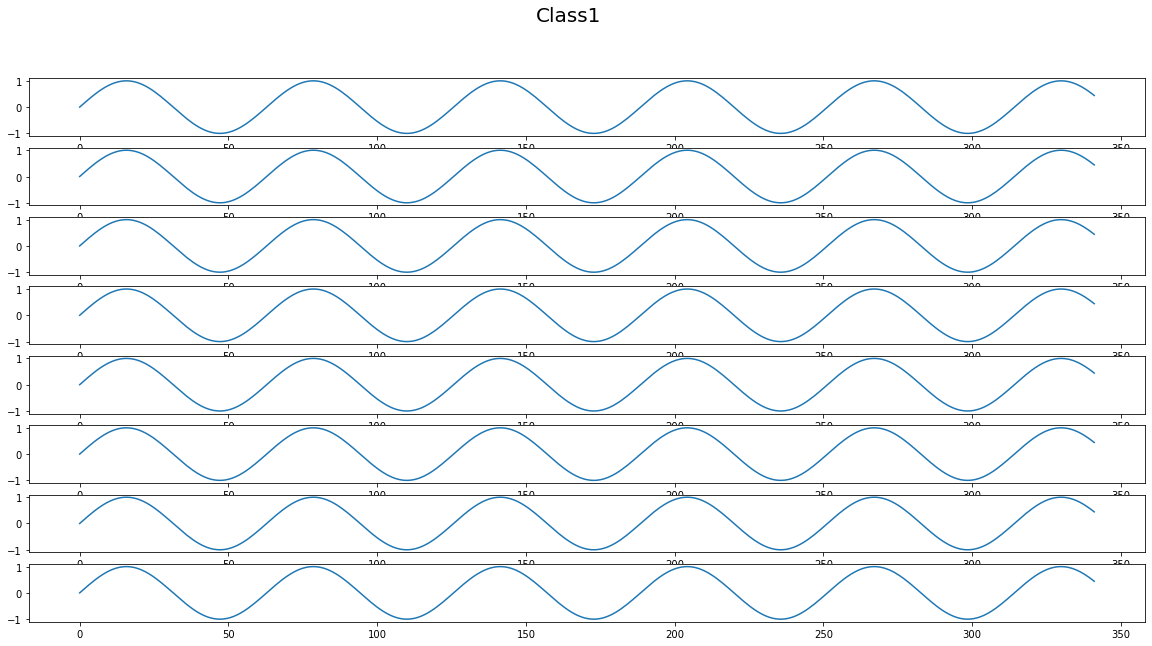

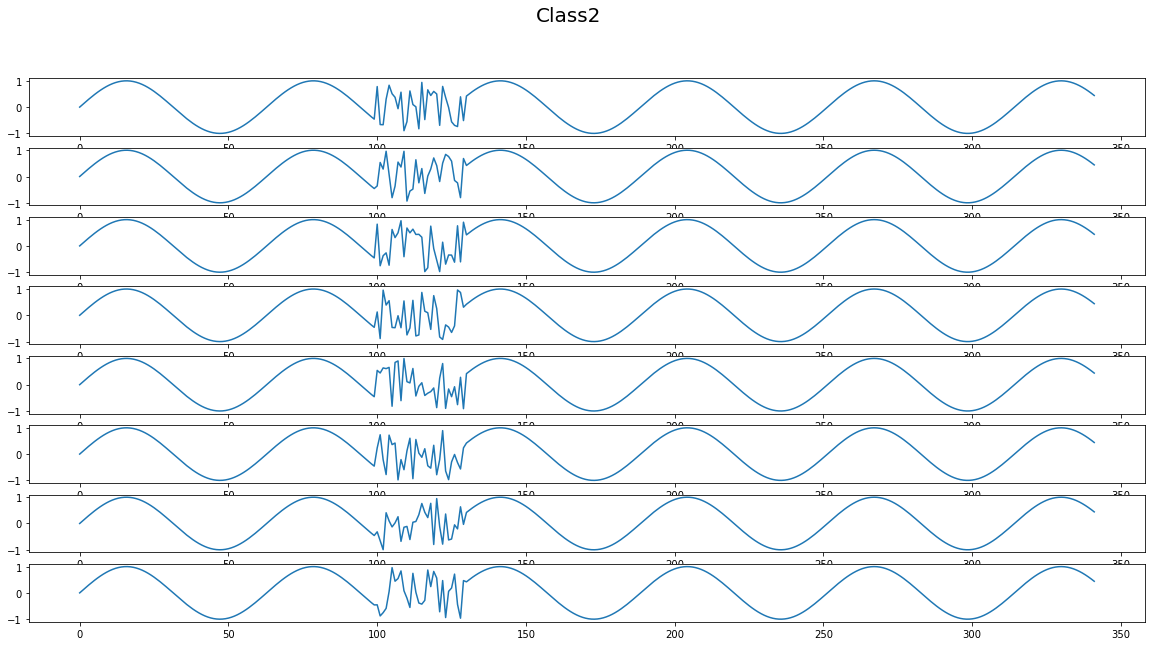

In [6]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Class1', fontsize=20)
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class1[7][i])
plt.show()
fig = plt.figure(figsize=(20,10))
fig.suptitle('Class2', fontsize=20)
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class2[7][i])
    
plt.show()


In [7]:
label = [1]*100 + [0]*100
label_test = [1]*24 + [0]*24

label = np.array(label)
label_test = np.array(label_test)

all_class_1 = Class1[:100] + Class2[:100]
all_class_test_1 = Class1[100:124] + Class2[100:124]


all_class = np.array([gen_cube(acl) for acl in all_class_1])
all_class_test = np.array([gen_cube(acl) for acl in all_class_test_1])

X_train = all_class
y_train = label
X_test = all_class_test
y_test = label_test


In [8]:
def numpy_to_tf_input(numpy_input):
    """
    Converts a NumPy-style input array to a TensorFlow-style input array.
    
    Args:
        numpy_input (np.ndarray): Input array in NumPy format with shape [batch_size, channels, height, width].
        
    Returns:
        tf_input (np.ndarray): Input array in TensorFlow format with shape [batch_size, height, width, channels].
    """
    # Transpose the array to move the channel dimension to the last axis
    transposed_input = np.transpose(numpy_input, (0, 2, 3, 1))
    return transposed_input

In [9]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
def unison_shuffled_copies(a, b,c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    
    p = np.random.permutation(len(a))
    return a[p], b[p],c[p]

X_train,y_train,all_class_shuffled = unison_shuffled_copies(X_train,y_train,np.array(all_class_1))
X_test,y_test,all_class_test_shuffled = unison_shuffled_copies(X_test,y_test,np.array(all_class_test_1))


In [10]:
X_train = numpy_to_tf_input(X_train)
X_test = numpy_to_tf_input(X_test)
X_train.shape,X_test.shape


((200, 8, 342, 8), (48, 8, 342, 8))

In [11]:
def make_model(input_shape, n_filter_list=[16,16,32,32,64], kernel_size=(3,3), num_classes=2):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=n_filter_list[0], kernel_size=kernel_size, padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    for iconv in range(1,len(n_filter_list)):
        if iconv==len(n_filter_list)-1:
            model.add(keras.layers.Conv2D(filters=n_filter_list[iconv], kernel_size=kernel_size, padding="same",name='last-conv'))
        else:
            model.add(keras.layers.Conv2D(filters=n_filter_list[iconv], kernel_size=kernel_size, padding="same"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    return model

In [12]:
tf.random.set_seed(42)
model = make_model(input_shape=X_train.shape[1:], n_filter_list=[128,128,256,256,256], kernel_size=(1,3), num_classes=2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 342, 128)       3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 342, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 342, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 342, 128)       49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 342, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 342, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 342, 256)       9

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
7/7 [==============================] - 9s 386ms/step - loss: 0.4920 - accuracy: 0.7100 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 1s 115ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 1s 114ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.7030 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 1s 121ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7163 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 1s 113ms/step - loss: 4.6455e-04 - accuracy: 1.0000 - val_loss: 0.7303 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 1s 111ms/step - loss: 3.2069e-04 - accuracy: 1.0000 - val_loss: 0.7440 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 1s 113ms/step - loss: 2.0711e-04 - accuracy: 1.0000 - val_loss: 0.7578 - val_accuracy: 0.5000
E

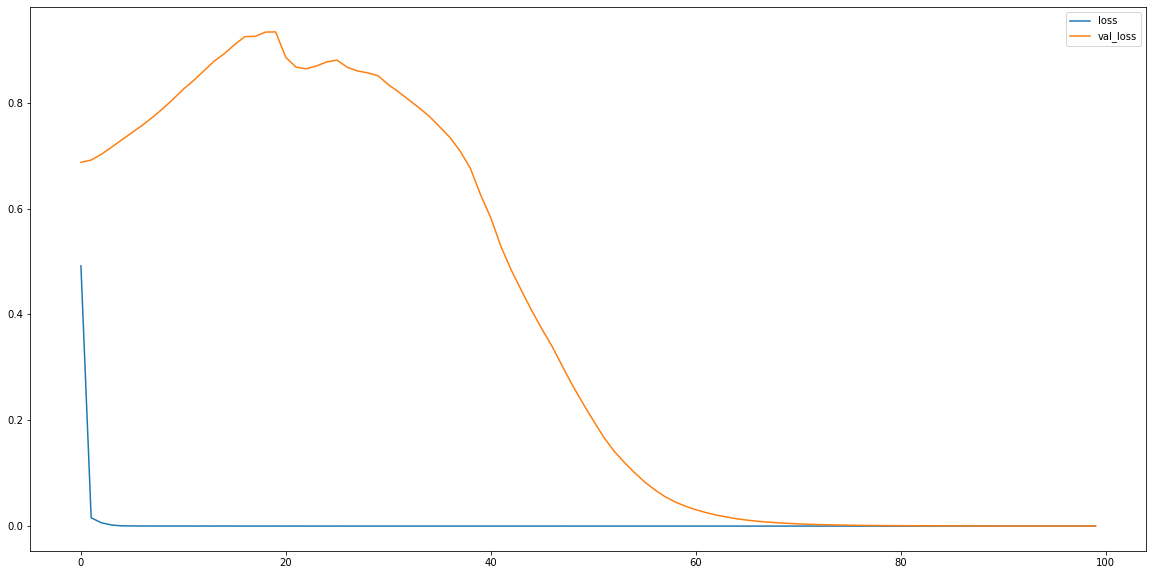

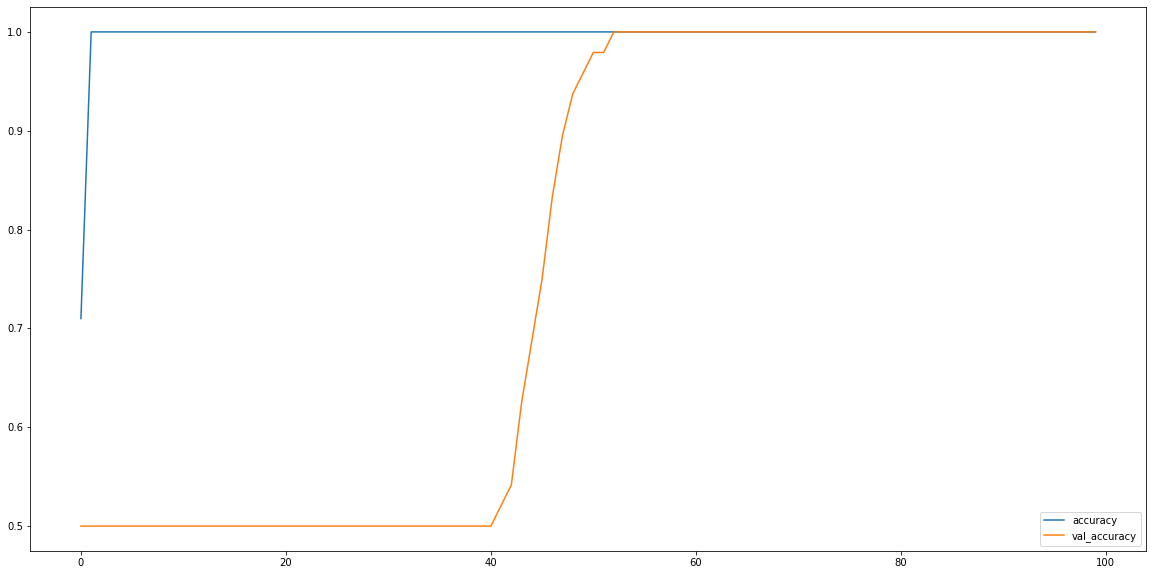

In [14]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()


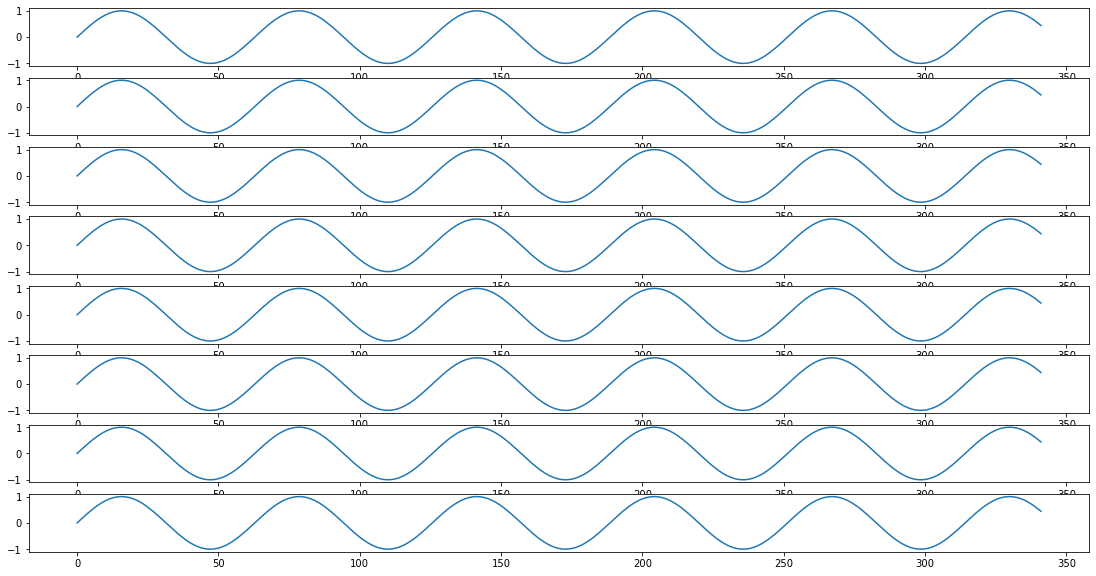

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

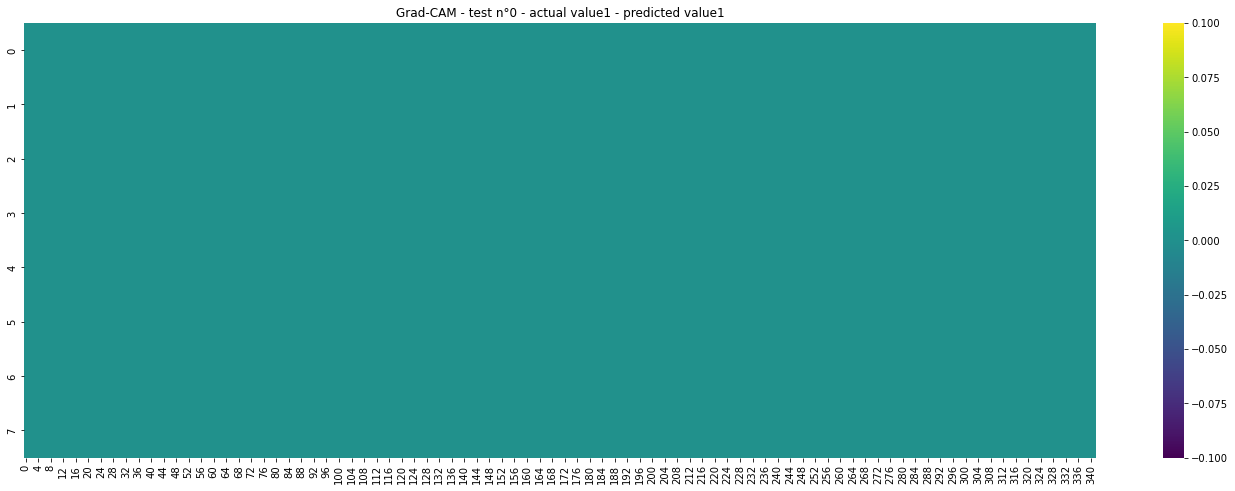

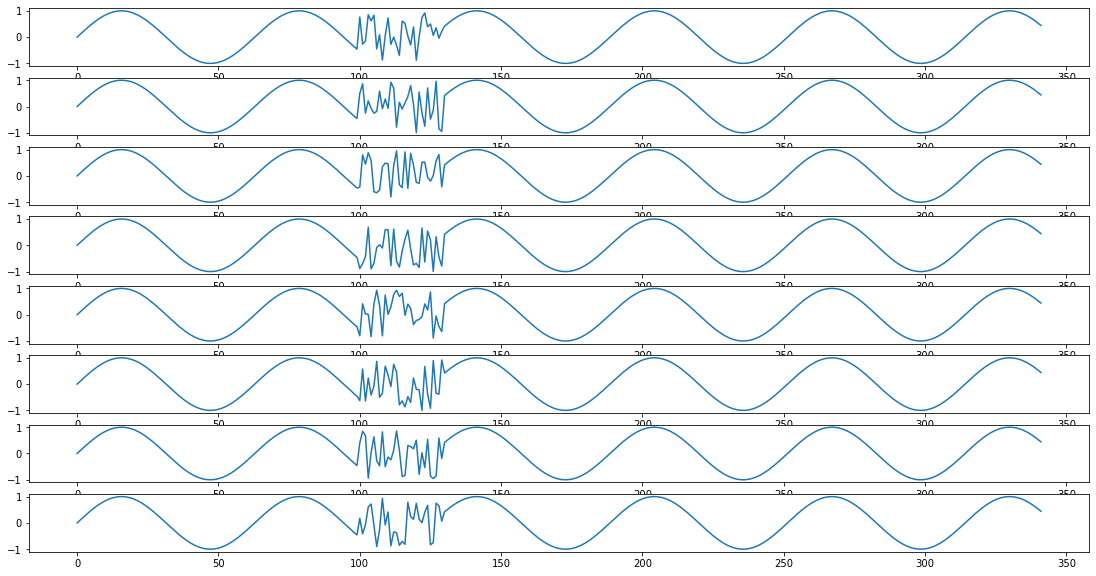

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

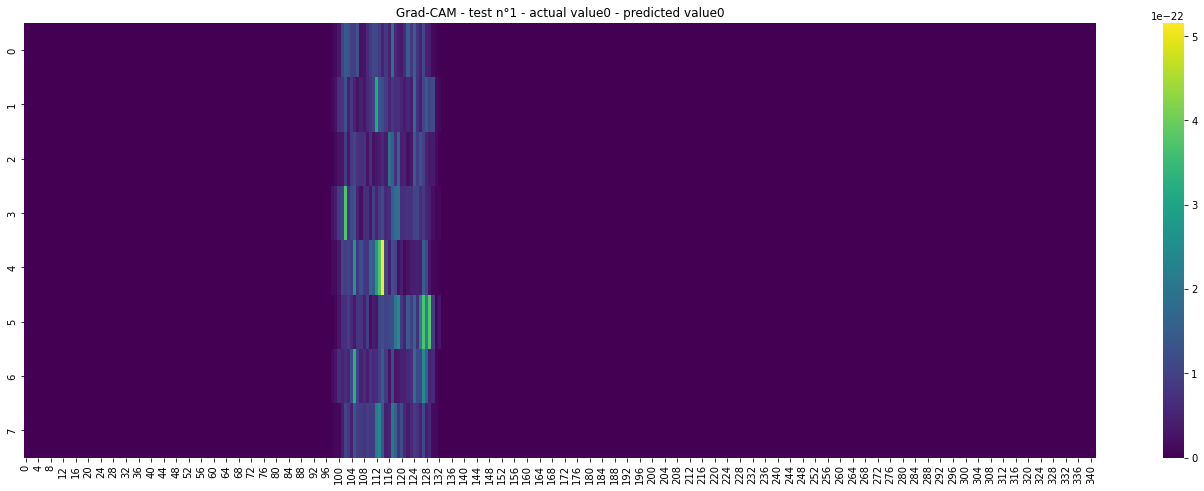

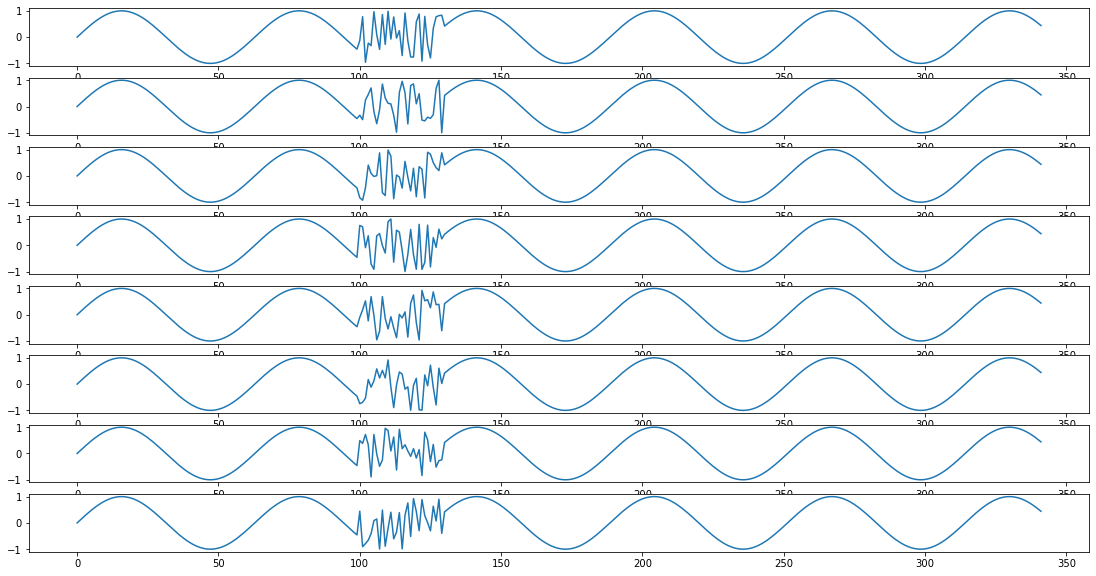

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

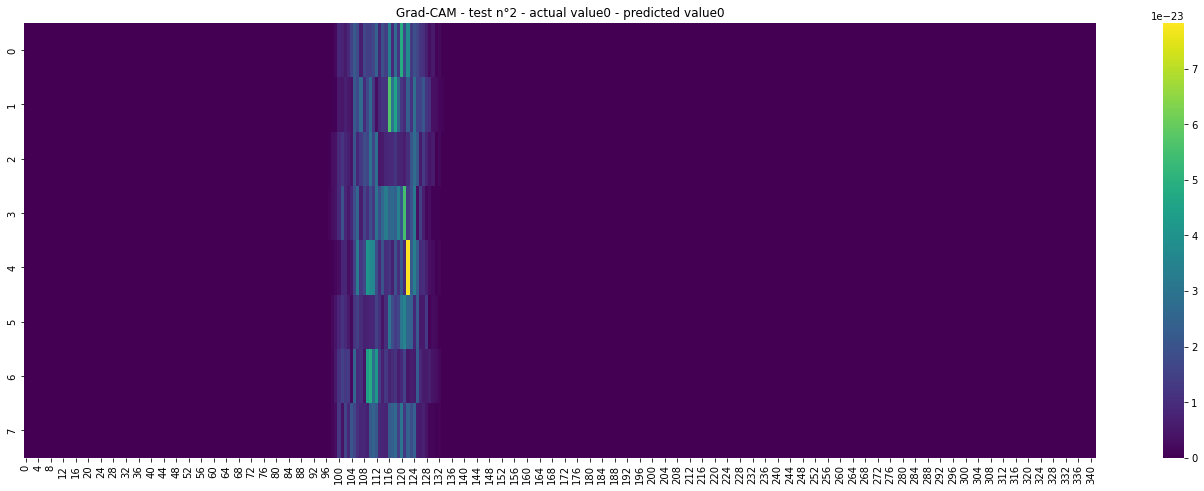

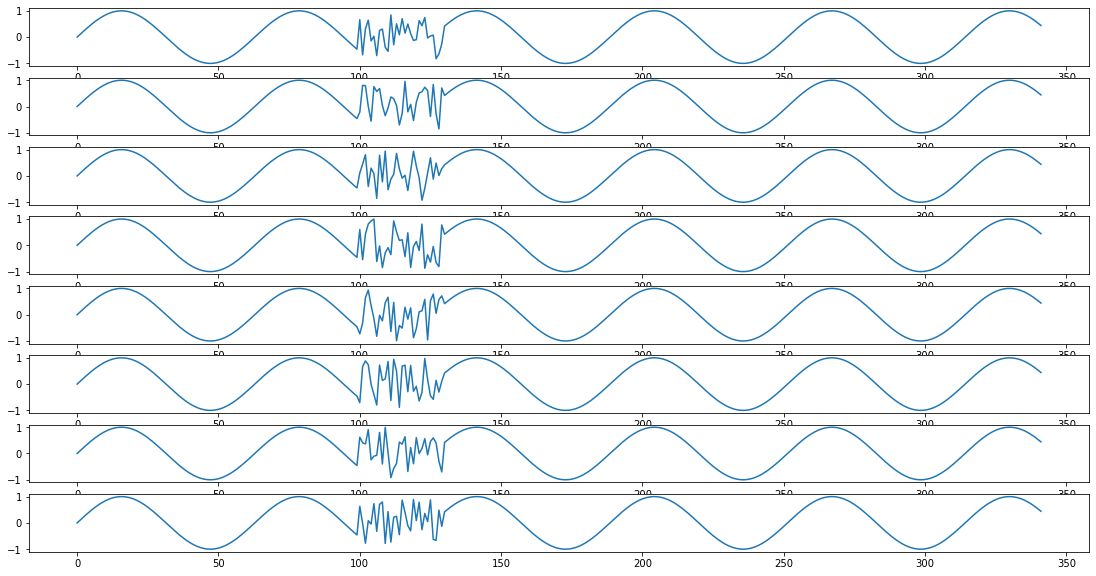

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

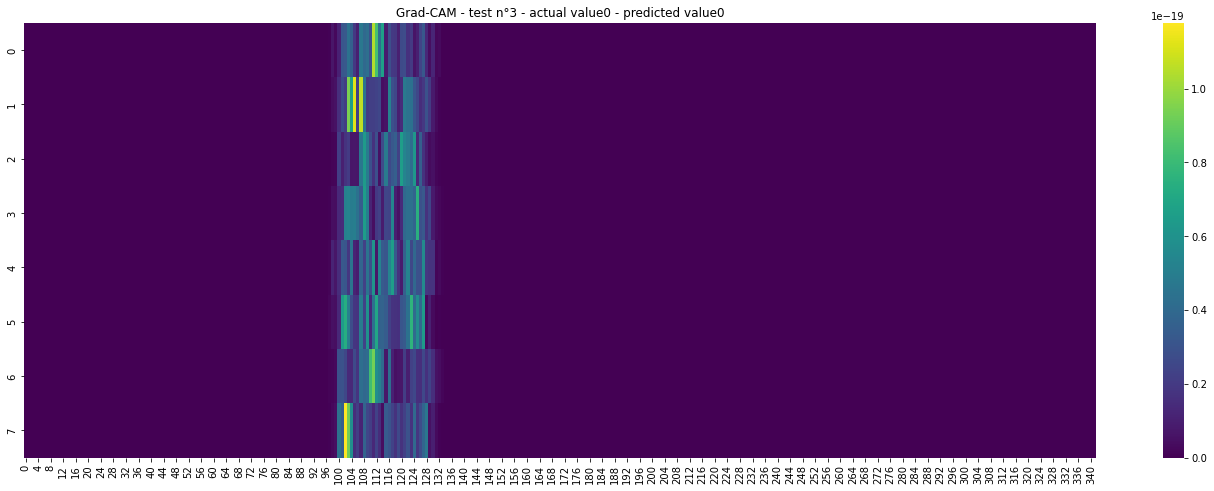

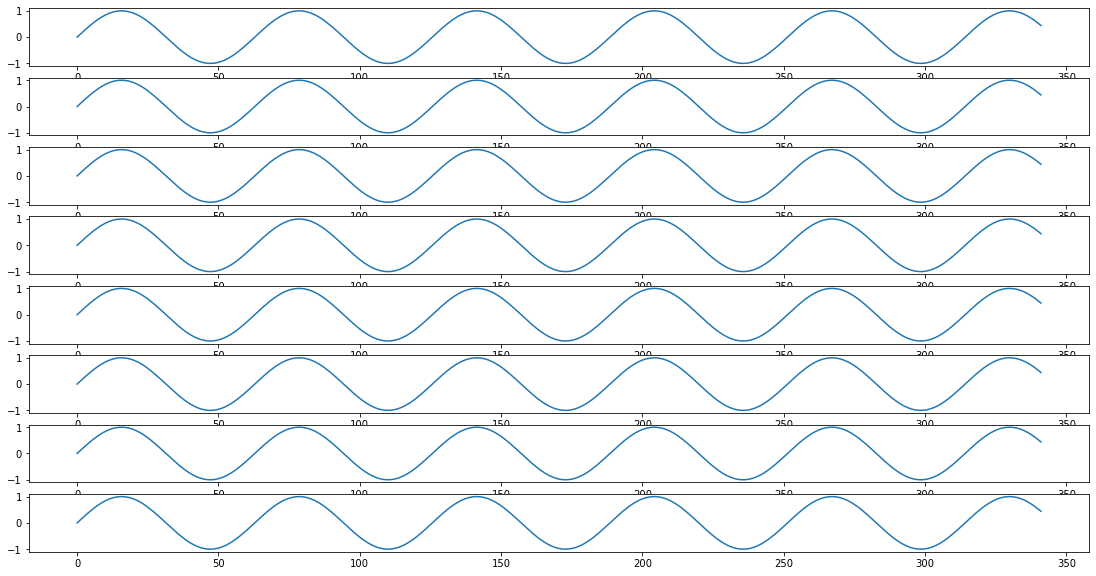

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

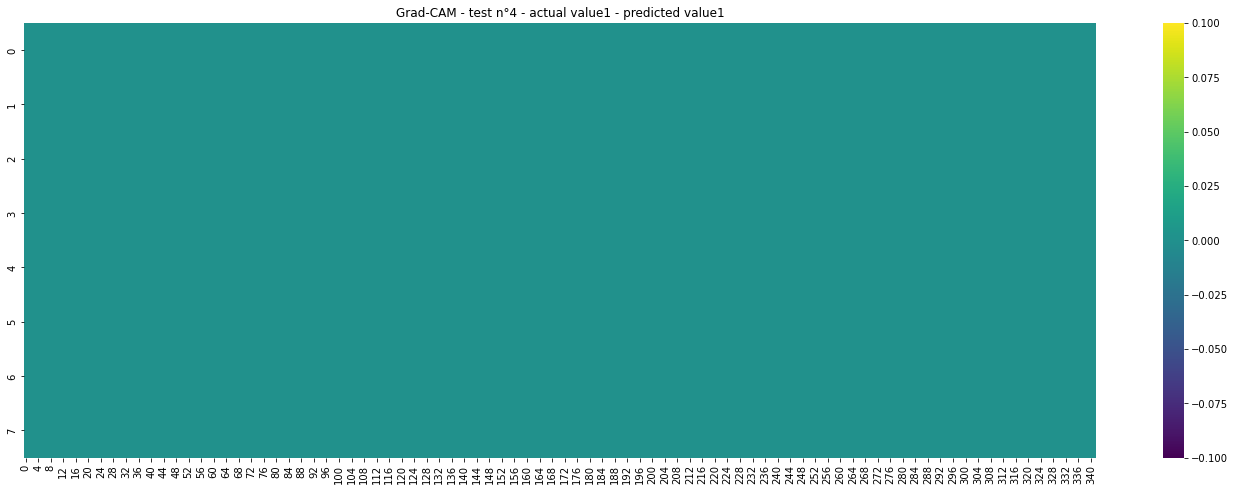

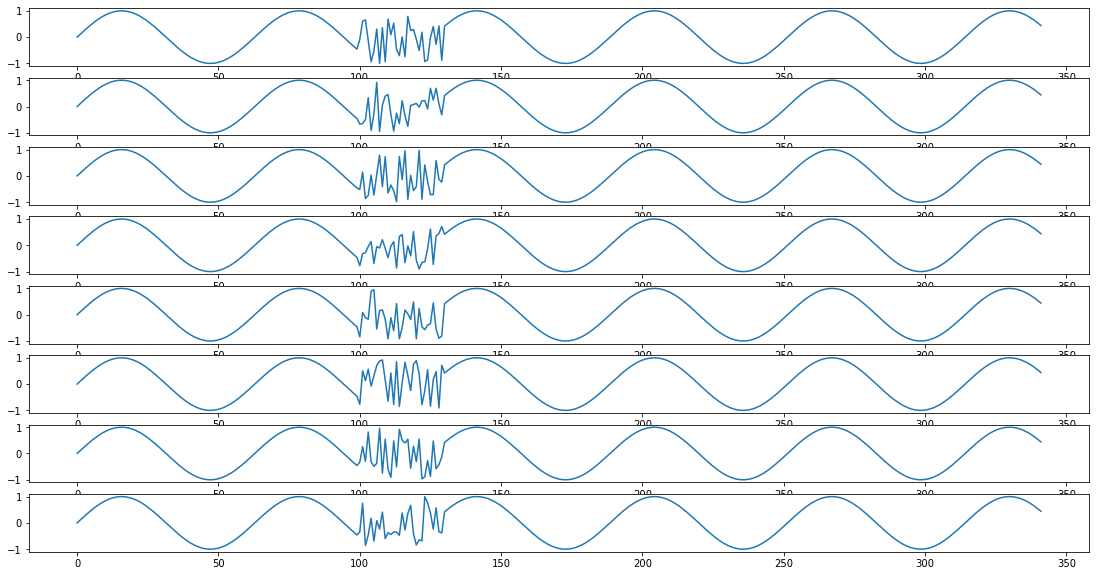

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

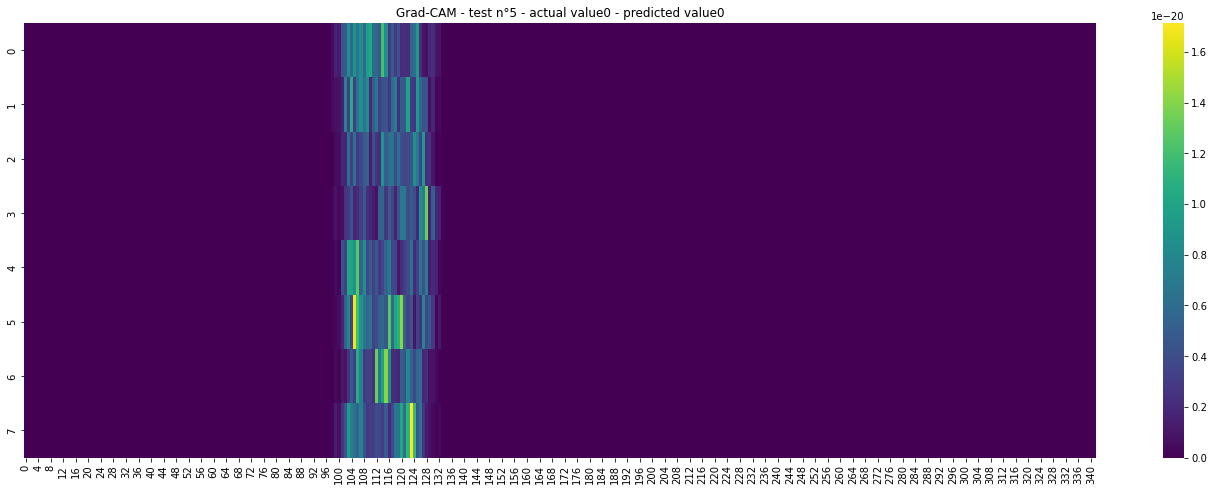

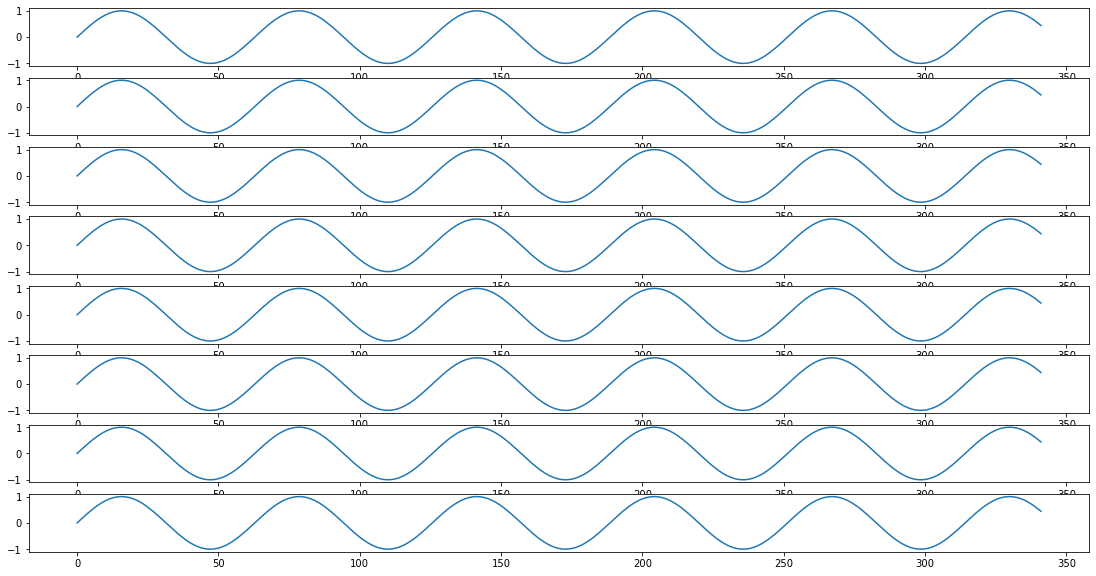

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

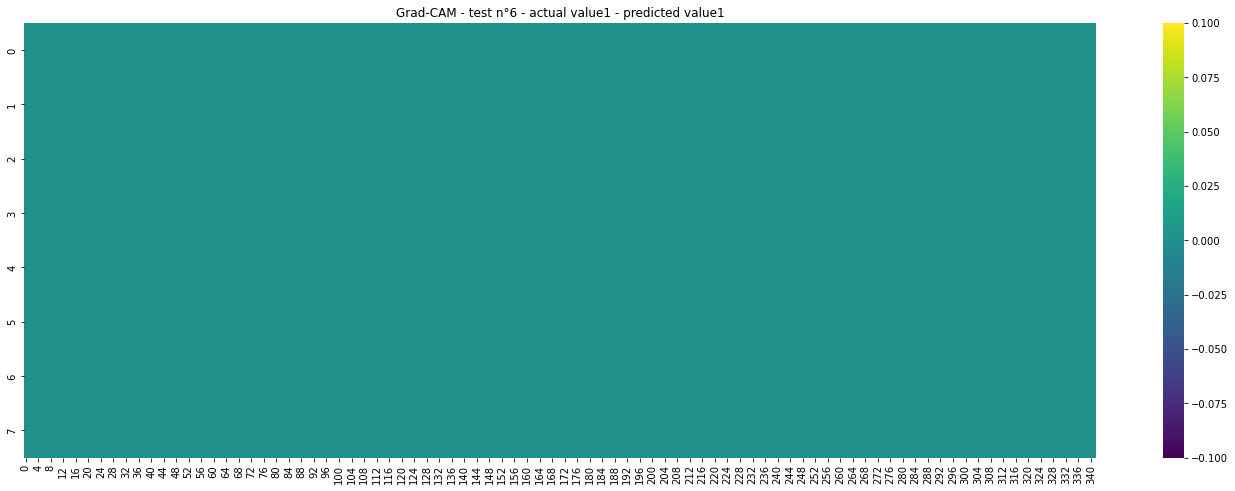

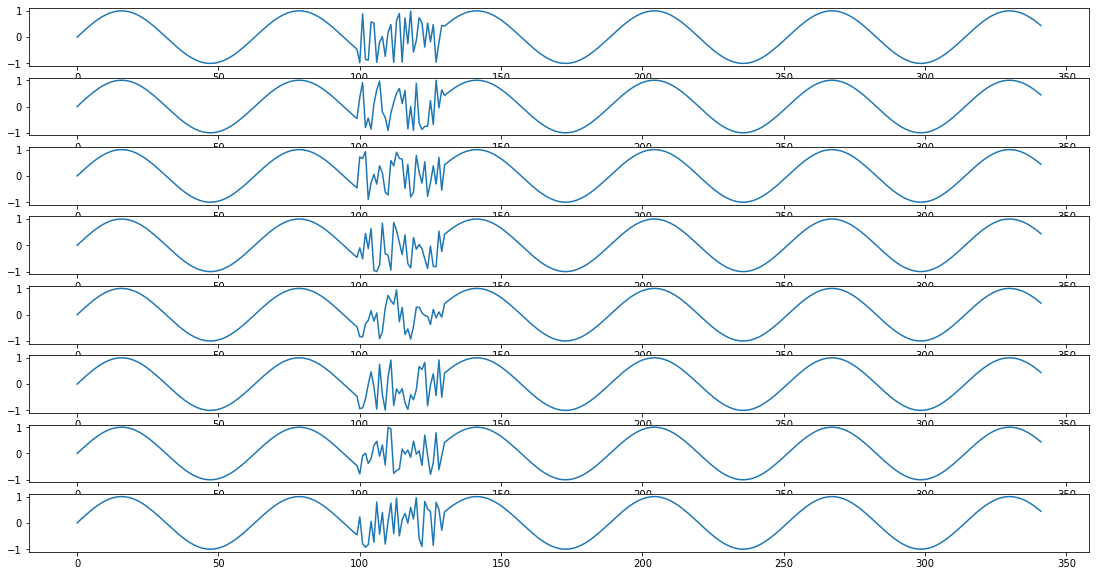

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

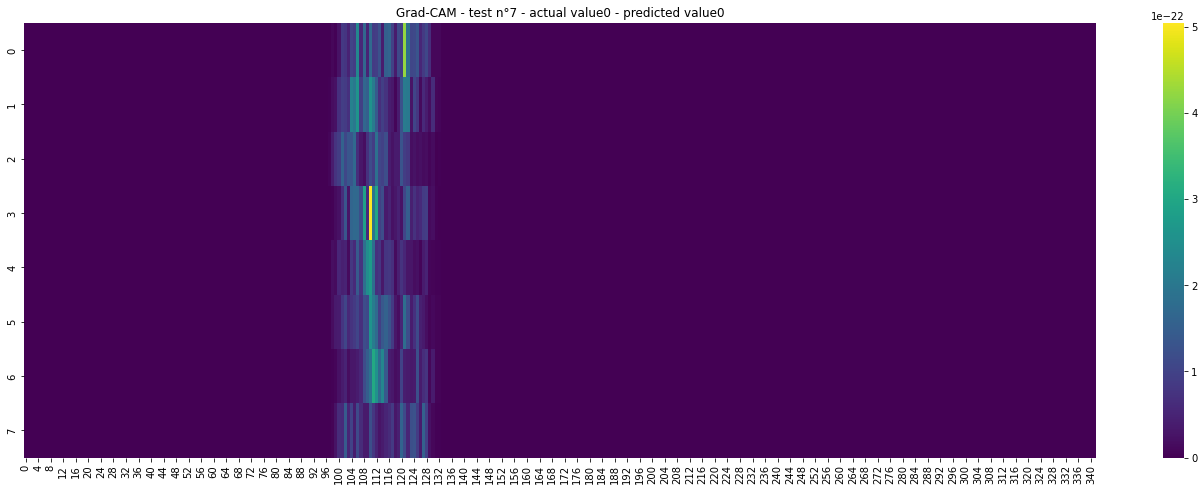

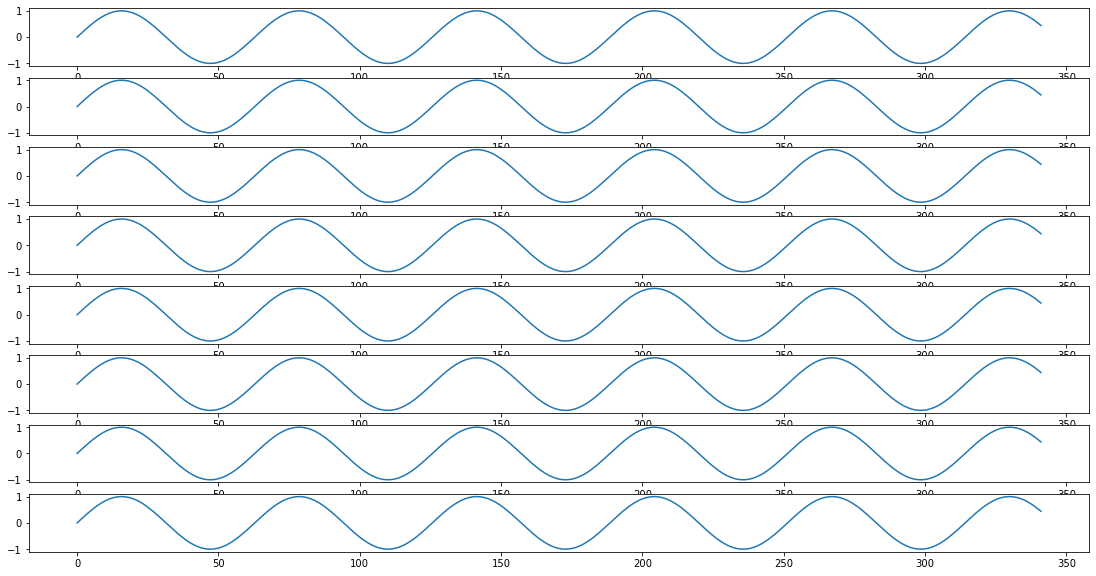

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

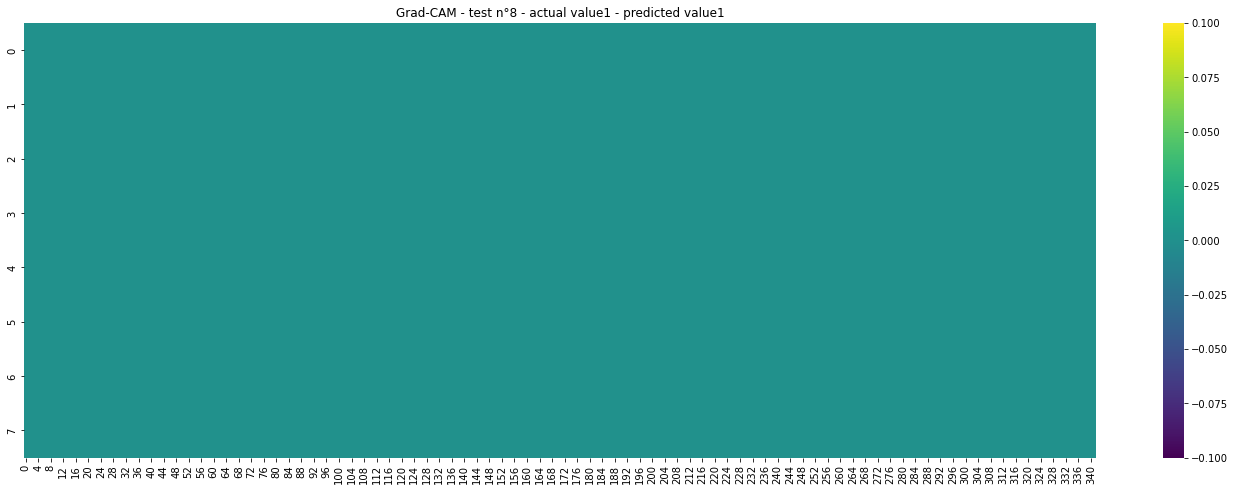

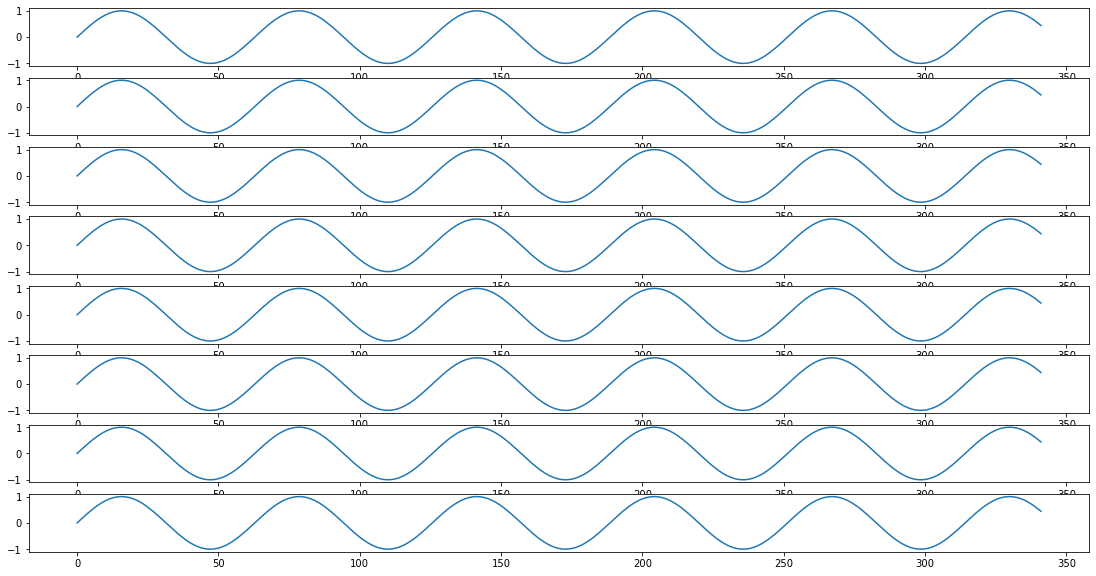

(8, 342, 8)


  0%|          | 0/200 [00:00<?, ?it/s]

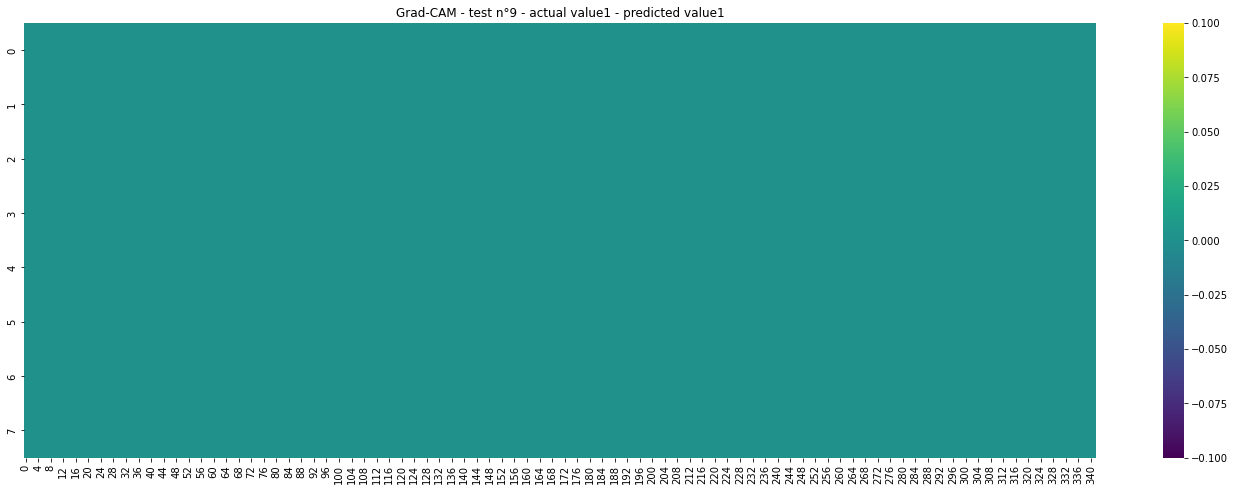

In [15]:
DCAM_m = DCAM(model, 'last-conv')
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

for i in range(10):
    plt.figure(figsize=(19,10))
    for j in range(len(all_class_test_shuffled[i])):
        plt.subplot(len(all_class_test_shuffled[i]),1,1+j)
        plt.plot(all_class_test_shuffled[i][j])
    plt.show()
    print(X_test[i].shape)
    img_array = X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 8)



    heatmap , permutation_success = DCAM_m.run(
    instance=all_class_test_shuffled[i],
    nb_permutation=200,
    label_instance=y_test[i])
    
    
    
    plt.figure(figsize=(24, 8))
    plt.title('Grad-CAM - test n°'+str(i) + ' - actual value' + str(y_test[i]) + ' - predicted value' + str(predictions[i]))
    sns.heatmap(heatmap, cmap='viridis'
    )
    plt.show()